In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
from model import *
from dataset import *
import util
import json
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader

matplotlib.rc('text', usetex=True)

# Load model and data

In [2]:
#model_idx = 'hd5-860835'
model_idx = 'hd5-4372116203'

In [3]:
config_path = f'training/{model_idx}/config.json'
with open('default_settings.json') as f:
        config = json.load(f)
with open(config_path) as f:
    util.dict_update(config, json.load(f))
data_train, data_val, data_test = util.dataset_from_config(config, filter_non_train=False, close_file=False)
model = util.model_from_config(config)

After Flavor filter 1622725 / 1762366 events remain.
After Current filter 1479022 / 1762366 events remain.
Classes [0 1]; Class counts [ 388787 1090235]
Reduced dataset to 388787 samples per class (777574 / 1762366)
(1762366,) (777574,)
(220296,) (220296,)
(220295,) (220295,)


In [4]:
if torch.cuda.is_available():
        model = model.cuda()
model.load_state_dict(torch.load(f'training/{model_idx}/model_1'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
test_loader = DataLoader(data_test, batch_size=config['training']['batch_size'], shuffle=config['dataset']['shuffle'], collate_fn=data_test.collate, drop_last=False)

In [6]:
metrics = defaultdict(float)
y_pred = np.zeros(len(test_loader.dataset))
y_true = np.zeros(len(test_loader.dataset))
total_loss = 0
model.eval()
for batch_idx, (inputs, y_i, _) in enumerate(test_loader):
    print(f'\rEvaluating {batch_idx + 1} / {len(test_loader)}', end='\r')
    y_pred_i = model(*inputs)
    y_pred[batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size] = y_pred_i.data.cpu().numpy().squeeze()
    y_true[batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size] = y_i.data.cpu().numpy().squeeze()

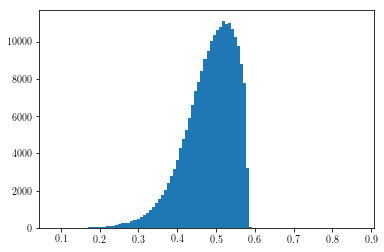

In [7]:
y_model = (y_pred >= .5).astype(np.int).flatten()
_ = plt.hist(y_pred, bins=100)

In [8]:
delta_llh = np.array(data_test.file['DeltaLLH'])[data_test._idxs]
y_baseline = (delta_llh >= 2.0).astype(np.uint8)

In [9]:
logits_model = y_pred
y_pred = (logits_model >= .5).astype(np.uint8)
acc_model = (y_pred == data_test.targets).sum() / y_pred.shape
acc_baseline = (y_baseline == data_test.targets).sum() / y_baseline.shape
acc_model, acc_baseline

(array([0.52751538]), array([0.61664132]))

# Check integrity of tracks in data

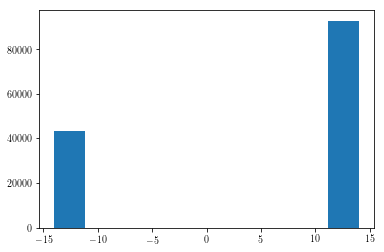

In [10]:
track_idx = data_test.targets > 0
_ = plt.hist(data_test.file['PDGEncoding'][track_idx])

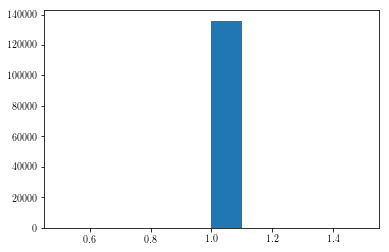

In [11]:
_ = plt.hist(data_test.file['InteractionType'][track_idx])

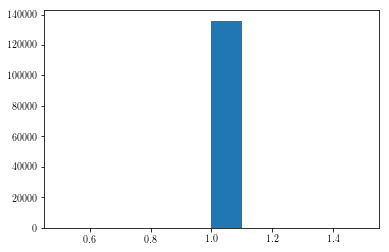

In [12]:
has_no_track_length = np.isnan(data_test.file['TrackLength'])
_ = plt.hist(data_test.targets[~has_no_track_length])

In [13]:
np.unique(data_test.file['PDGEncoding'][~has_no_track_length], return_counts=True)

(array([-14.,  14.]), array([43215, 92740]))

False

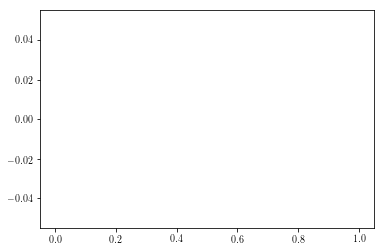

In [14]:
mask = (~np.isnan(data_test.file['TrackLength'])).copy()
mask[data_test.targets > 0] = False

track_lengths = data_test.file['TrackLength'][mask]
plt.hist(track_lengths, bins=200)

mask.any()

# Check Batchnorm of model

In [15]:
model.graph_convolutions[1].batchnorm.running_variance

tensor([0.0253, 0.1086, 0.3398, 0.8052, 0.0900, 0.0797, 0.1417, 0.0364, 0.1584,
        0.0335, 0.0155, 0.0610, 0.0546, 0.4946, 0.0480, 0.1403, 0.0804, 0.3638,
        0.0310, 0.0724, 0.0530, 0.1165, 0.0263, 0.0510, 0.3751, 0.1446, 0.0495,
        0.0941, 0.0237, 0.0613, 0.1708, 0.3740, 0.1328, 0.0489, 0.1184, 0.0870,
        0.0440, 0.1790, 0.2343, 0.1704, 0.0365, 0.1618, 0.0396, 0.0289, 0.0567,
        0.1287, 0.0298, 0.0516, 0.4680, 0.3003, 0.1249, 0.2751, 0.0276, 0.3588,
        0.0544, 0.1720, 0.0476, 0.0541, 0.0852, 0.0208, 0.2889, 0.1214, 0.1277,
        0.0506], device='cuda:0')

In [16]:
data_test.features.mean(0), data_test.features.std(0)

(array([2.59432413e-01, 3.18244985e-01, 2.75823390e-01, 3.13502575e-01,
        7.65729437e-02, 1.35385516e-01, 9.29639213e-02, 3.36651782e-01,
        6.20712460e-05, 1.84652407e-03, 3.98547371e-02, 2.92116724e-12,
        1.20205732e-11, 6.71586071e-12]),
 array([0.41890392, 0.47106593, 0.43108752, 0.4120964 , 0.45855625,
        0.49347819, 0.46583408, 0.34005416, 0.9992484 , 0.99924374,
        0.99920548, 0.99923966, 0.99923966, 1.        ]))

In [17]:
1 / model.kernel.inverse_sigma

tensor([1.0027], device='cuda:0', grad_fn=<MulBackward0>)

In [18]:
# Verify that batchnorm is working in testing mode
for X, y, _ in test_loader:
    break
X, C, M, F = X
y_pred1 = model(X, C, M, F)
y_pred2 = model(X[:32], C[:32], M[:32], F[:32])
(y_pred1[:y_pred2.size(0)] == y_pred2).all()

tensor(1, device='cuda:0', dtype=torch.uint8)

## Predict model on all data that was discarded during filtering

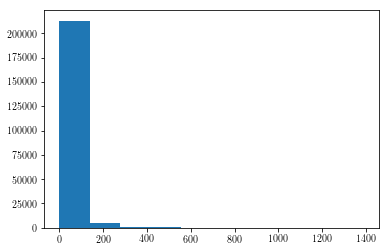

In [19]:
charge = np.array(data_test.file['TotalCharge'])[data_test._idxs]
pdg_encodings = np.array(data_test.file['PDGEncoding'])[data_test._idxs]
interaction_types = np.array(data_test.file['InteractionType'])[data_test._idxs]
muon_energy = np.array(data_test.file['MuonEnergy'])[data_test._idxs]
cascade_energy = np.array(data_test.file['CascadeEnergy'])[data_test._idxs]
# Fill NaNs with zeros
muon_energy[np.isnan(muon_energy)] = 0.0
cascade_energy[np.isnan(cascade_energy)] = 0.0
total_energy = muon_energy + cascade_energy
#_ = plt.hist(np.log(np.array(data_train.file['TotalCharge'])))
#plt.hist(charge)
_ = plt.hist(total_energy)

In [20]:
def binned_ppr(y_pred, y_gnd, values, number_bins=50, max_value=.1, min_value=50.0):
    """ Calculates the ppr binned in charges. 
    
    Parameters:
    -----------
    y_pred : ndarray, shape [N]
        Predictions.
    y_gnd : ndarray, shape [N]
        Ground truths.
    values : ndarray, shape [N]
        Values to be binned.
    number_bins : int, optional
        The number of bins.
    min_value : float, optional
        Minumum value for bins.
    max_value : float, optional
        Maximum value for bins.
    
    Returns:
    --------
    ppr : ndarray, shape [bins + 1]
        Positive predicted values for each bin.
    sigma_ppr : ndarray, shape [bins + 1]
        Uncertainty of predicted positive values for each bin.
    bins : ndarray, shape [bins]
        Bin edges.
    """
    log_values = np.log10(values)
    # Bin all charges
    bins = np.linspace(np.log10(min_value), np.log10(max_value), number_bins)
    
    bin_counts, _ = np.histogram(log_values, bins=bins)
    # Bin positive predictions
    pos_bin_counts, _ = np.histogram(log_values[y_pred > 0], bins=bins)
    ppr = pos_bin_counts / bin_counts
    
    # Calculate uncertainty
    sigma_bin_counts = np.sqrt(bin_counts)
    sigma_pos_bin_counts = np.sqrt(pos_bin_counts)
    
    sigma_ppr = np.sqrt(
        ppr**2 * ((sigma_bin_counts / bin_counts)**2 + (sigma_pos_bin_counts / pos_bin_counts)**2))
    return ppr, sigma_ppr, bins, pos_bin_counts, bin_counts

In [21]:
def ppr_plot(y_pred, y_gnd, charges, pdg_encodings, interaction_types, title, plots, 
             bins=50, xlabel='log(Integrated Charge) (pe)', min_charge=0.1, max_charge=50.0, filepath=None):
    """ Creates subplots for the ppr by neutrino flavour (and interaction type). """
    pgd_encodings = np.abs(pdg_encodings)
    fig = plt.figure(figsize=(20, 10))
    plt.xticks(fontsize=24)
    plt.xscale('log')
    
    for plot_label in plots:
        color, pdg_encoding, interaction_type = plots[plot_label]
        if interaction_type is None:
            mask = pdg_encodings == pdg_encoding
        else:
            mask = np.logical_and((pdg_encodings == pdg_encoding), (interaction_types == interaction_type))
                           
        ppr, sigma, bin_edges, _, _ = binned_ppr(y_pred[mask], y_gnd[mask], charges[mask], number_bins=bins, 
                                           min_value=min_charge, max_value=max_charge)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        plt.fill_between(
            np.power(10, bin_edges[1:]),
            ppr - sigma,
            ppr + sigma,
            color=color,
            alpha=.1,
            step='pre',
        )
        plt.errorbar(
            np.power(10, bin_edges[1:]),
            ppr,
            color=color,
            label=plot_label,
            linestyle='steps',
        )
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel('Positive Prediction Rate', fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylim(0, 1)
    #plt.legend(loc='left', bbox_to_anchor=(1.0, 1.0), fontsize=20)
    plt.legend(fontsize=24)
    plt.title(title, fontsize=24)
    if filepath: plt.savefig(filepath)

In [22]:
plots = {
    '$\\nu_e$ NC' : ('blue', 12, 2),
    '$\\nu_e$ CC' : ('black', 12, 1),
    '$\\nu_\\mu$ CC' : ('green', 14, 1),
    '$\\nu_\\mu$ NC' : ('red', 14, 2),
    #'nue' : ('blue', 12, None),
    #'nutau' : ('purple', 16, None),
    '$\\nu_\\tau$ NC' : ('grey', 16, 2),
    '$\\nu_\\tau$ CC' : ('brown', 16, 1)

}

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


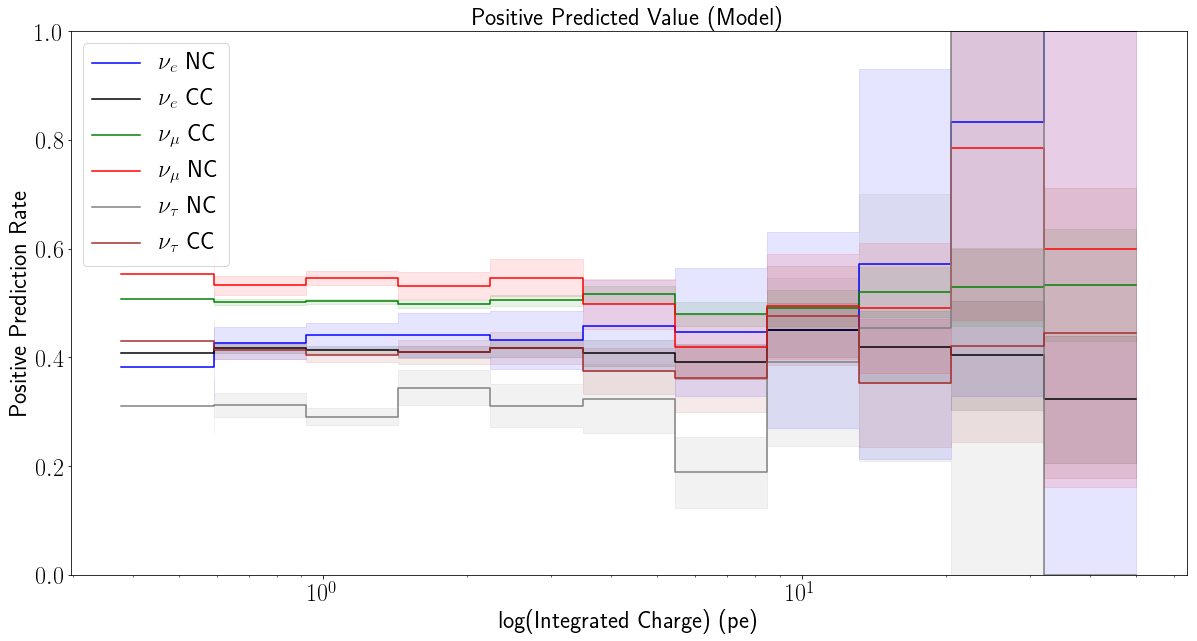

In [23]:
ppr_plot(y_model, data_test.targets, charge, pdg_encodings, interaction_types,
        'Positive Predicted Value (Model)', plots, bins=15)

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


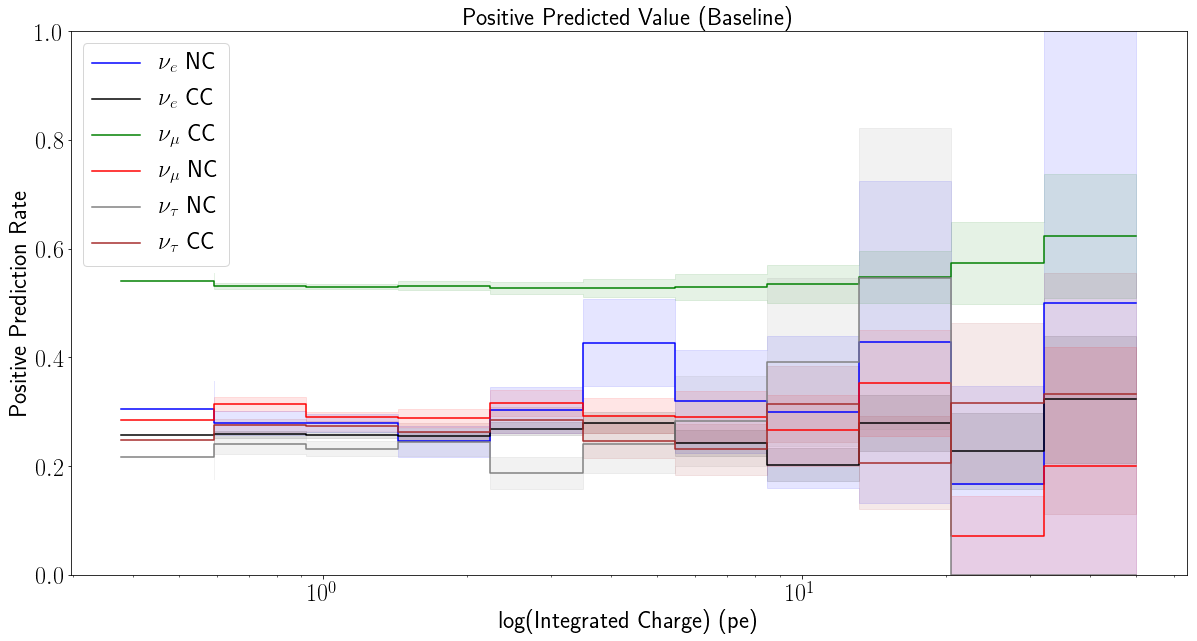

In [24]:
ppr_plot(y_baseline, data_test.targets, charge, pdg_encodings, interaction_types,
        'Positive Predicted Value (Baseline)', plots, bins=15)

# Check if mixing the data results in different plots

In [25]:
test_loader_shuffled = DataLoader(data_test, batch_size=config['training']['batch_size'], shuffle=True, collate_fn=data_test.collate, drop_last=False)

metrics = defaultdict(float)
y_pred_shuffled = np.zeros(len(test_loader.dataset))
y_true_shuffled = np.zeros(len(test_loader.dataset))
total_loss = 0
model.eval()
for batch_idx, (inputs, y_i, weights) in enumerate(test_loader_shuffled):
    print(f'\rEvaluating {batch_idx + 1} / {len(test_loader_shuffled)}', end='\r')
    y_pred_i = model(*inputs)
    y_pred_shuffled[batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size] = y_pred_i.data.cpu().numpy().squeeze()
    y_true_shuffled[batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size] = y_i.data.cpu().numpy().squeeze()

# Evaluate model on filtered testing dataset

In [26]:
import dataset
idx_filter = dataset.hd5.event_filter(data_test.file, min_track_length=70, max_cascade_energy=10)

After Track Length filter 136796 / 220295 events remain.
After Cascade Energy filter 119703 / 220295 events remain.


/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:485: RuntimeWarning: invalid value encountered in less
  idx_removed = np.where(np.logical_and((track_length < min_track_length), has_track_length))[0]
/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:491: RuntimeWarning: invalid value encountered in greater
  idx_removed = np.where(np.logical_and((cascade_energy > max_cascade_energy), has_track_length))


In [27]:
(y_model[idx_filter] == data_test.targets[idx_filter]).sum() / idx_filter.sum()

0.617444842652231

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


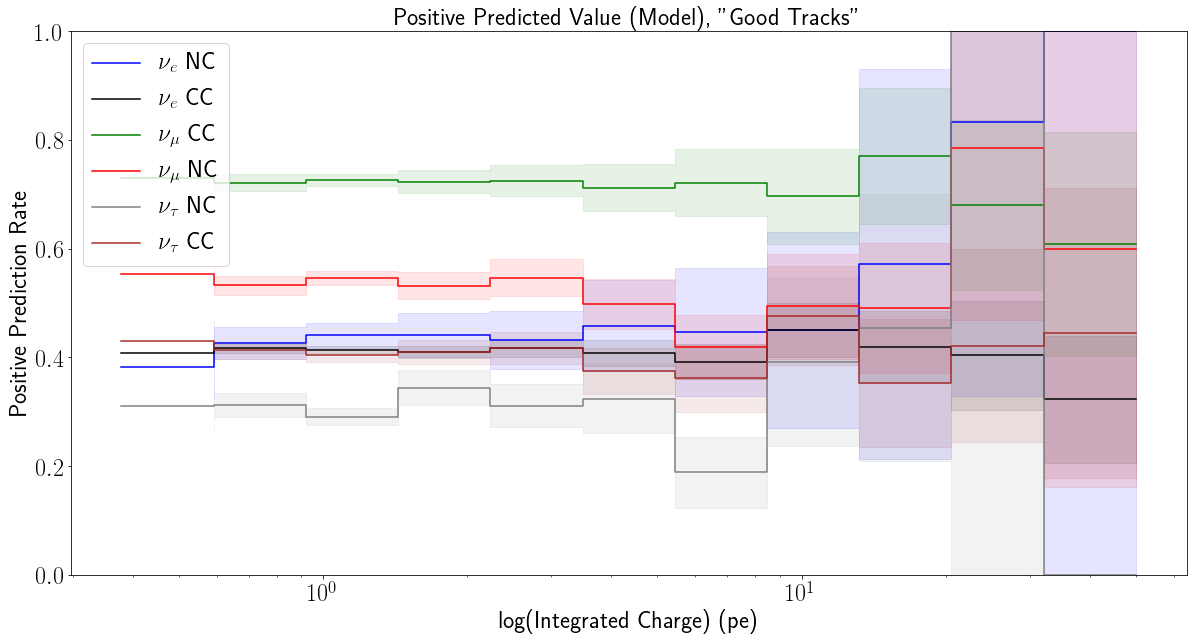

In [28]:
ppr_plot(y_model[idx_filter], data_test.targets[idx_filter], charge[idx_filter], pdg_encodings[idx_filter], interaction_types[idx_filter],
        'Positive Predicted Value (Model), "Good Tracks"', plots, bins=15)

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


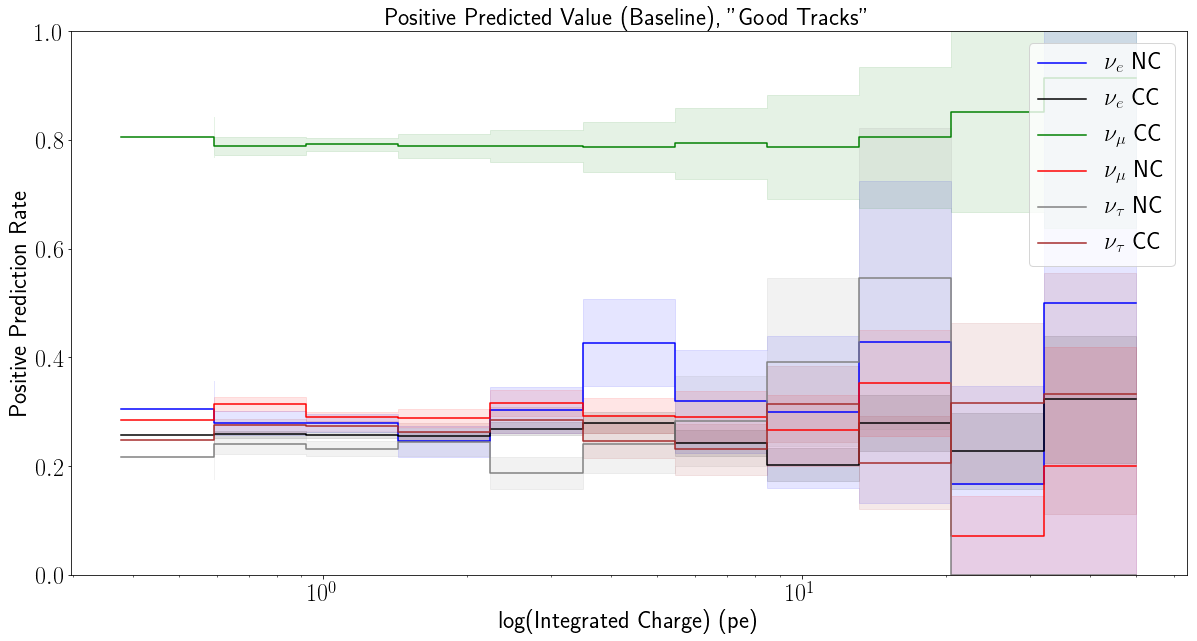

In [29]:
ppr_plot(y_baseline[idx_filter], data_test.targets[idx_filter], charge[idx_filter], pdg_encodings[idx_filter], interaction_types[idx_filter],
        'Positive Predicted Value (Baseline), "Good Tracks"', plots, bins=15)

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


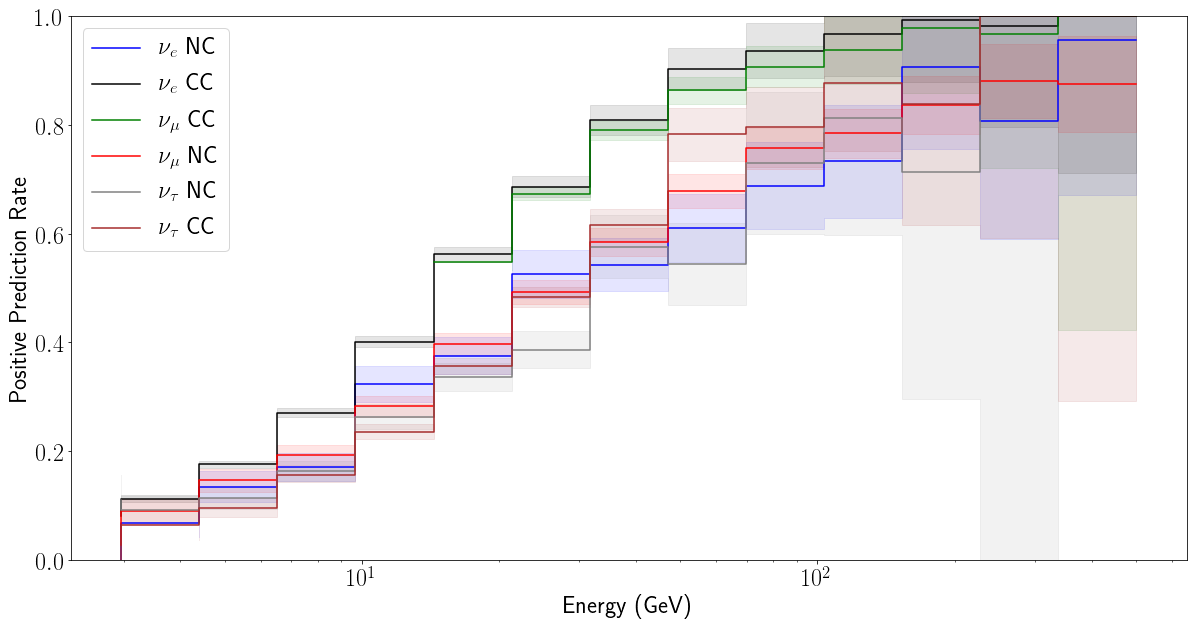

In [35]:
ppr_plot(y_model[idx_filter], data_test.targets[idx_filter], total_energy[idx_filter], pdg_encodings[idx_filter], interaction_types[idx_filter],
        None, plots, bins=15, min_charge=2.0, max_charge=500.0, xlabel='Energy (GeV)', filepath='plots/ppr_good_tracks.svg')

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


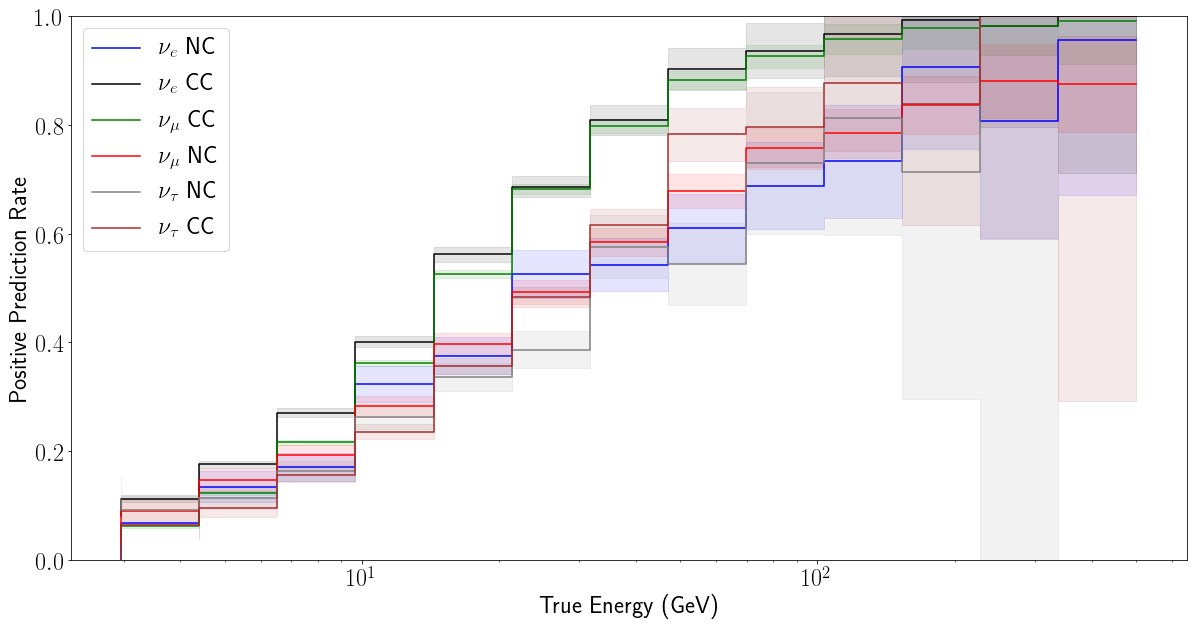

In [31]:
ppr_plot(y_model, data_test.targets, total_energy, pdg_encodings, interaction_types,
        None, plots, bins=15, min_charge=2.0, max_charge=500.0, xlabel='True Energy (GeV)', filepath='plots/ppr.svg')

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


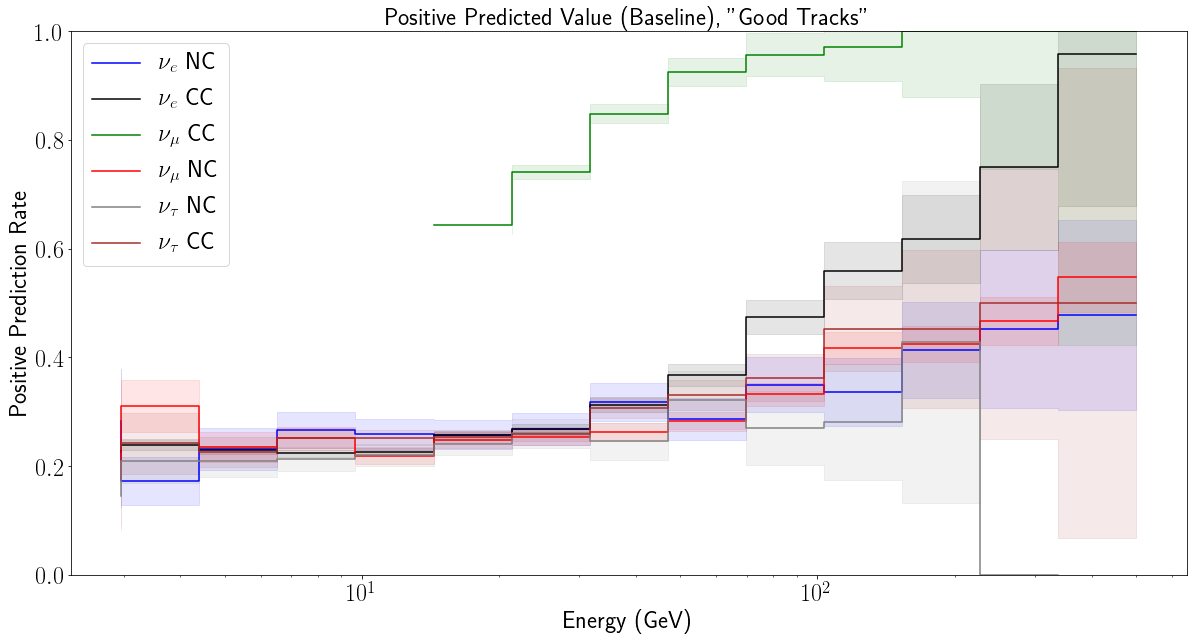

In [32]:
ppr_plot(y_baseline[idx_filter], data_test.targets[idx_filter], total_energy[idx_filter], pdg_encodings[idx_filter], interaction_types[idx_filter],
        'Positive Predicted Value (Baseline), "Good Tracks"', plots, bins=15, min_charge=2.0, max_charge=500.0, xlabel='Energy (GeV)')

In [33]:
numucc = np.logical_and(interaction_types == 1, np.abs(pdg_encodings) == 14)
nuecc = np.logical_and(interaction_types == 1, np.abs(pdg_encodings) == 12)
y_model[numucc].sum() / y_model[numucc].shape, y_model[nuecc].sum() / y_model[nuecc].shape

(array([0.49906955]), array([0.41052696]))

In [34]:
numuecc = np.logical_or(numucc, nuecc)
y_model[numucc].sum() / y_model[numuecc].shape

array([0.36666703])

In [35]:
total_energy[interaction_types == 2].mean(), total_energy[interaction_types == 1].mean()

(61.70178857544783, 28.464482645173273)

(array([ 1037.,  6656., 22716., 43507., 52185., 43223., 26221., 14050.,
         6597.]),
 array([0.        , 0.25555556, 0.51111111, 0.76666667, 1.02222222,
        1.27777778, 1.53333333, 1.78888889, 2.04444444, 2.3       ]),
 <a list of 9 Patch objects>)

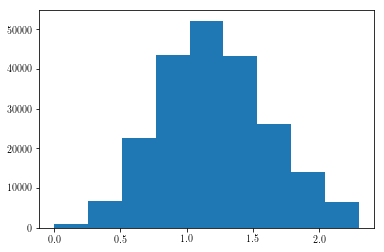

In [36]:
plt.hist(np.log10(total_energy), np.linspace(0, 2.3, 10)) 

In [37]:
def close_data():
    for data in (data_test, data_train, data_val):
        data.file.close()

# Correlation plots for trackness

In [38]:
data_test.file.keys()

<KeysViewHDF5 ['COGDistances', 'COGPrimaryX', 'COGPrimaryY', 'COGPrimaryZ', 'COGRecoX', 'COGRecoY', 'COGRecoZ', 'COGShiftedVertexX', 'COGShiftedVertexY', 'COGShiftedVertexZ', 'CascadeEnergy', 'ChargeFirstPulse', 'ChargeLastPulse', 'ChargeMaxPulse', 'DCFiducialPE', 'DeltaLLH', 'Distances', 'InteractionType', 'MuonEnergy', 'NeutrinoEnergy', 'NoFlux', 'NuMuFlux', 'NueFlux', 'NumberChannels', 'NumberVertices', 'PDGEncoding', 'PrimaryAzimuth', 'PrimaryX', 'PrimaryY', 'PrimaryZ', 'PrimaryZenith', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeFirstPulseShifted', 'TimeLastPulse', 'TimeLastPulseShifted', 'TimeMaxPulse', 'TimeMaxPulseShifted', 'TimeStd', 'TimeStdShifted', 'TotalCharge', 'TrackLength', 'VertexX', 'VertexY', 'VertexZ']>

In [39]:
zenith_true = np.array(data_test.file['PrimaryZenith'])
zenith_reco = np.array(data_test.file['RecoZenith'])

In [40]:
def corplot(xs, logits, xlabels, ylabel, bins=(15, 10), title=None, cols=2, filepath=None):
    n_figs = len(xs)
    rows = int(np.ceil(n_figs / cols))
    fig = plt.figure(figsize=(10 * cols, 10 * rows))
    
    for i, (x, xlabel) in enumerate(zip(xs, xlabels)):
        row = i // rows
        col = i % cols
        plt.subplot(rows, cols, i + 1)
        counts, xedges, yedges = np.histogram2d(x, logits, bins=bins)
        counts /= counts.sum(1).reshape((-1, 1)) + 1e-20
        #plt.imshow(counts.T, interpolation='nearest', label='normalized counts')
        plt.pcolor(xedges, yedges, counts.T)
        plt.xlabel(xlabel, fontsize=20)
        plt.ylabel(ylabel, fontsize=20)
    if title: fig.suptitle(title, fontsize=30)
    if filepath: plt.savefig(filepath)

In [41]:
pdg_encodings = np.array(data_test.file['PDGEncoding'])
interaction_type = np.array(data_test.file['InteractionType'])
delta_llh = np.array(data_test.file['DeltaLLH'])

In [42]:
import os
%pwd

'/media/dominik/d/uni/uare/icecube/NuIntClassification'

In [43]:
os.makedirs(f'./plots/{model_idx}', exist_ok=True)
for flavor, pdg in (('nue', 12), ('numu', 14), ('nutau', 16)):
    for current, interaction in (('cc', 1), ('nc', 2)):
        mask = np.logical_and(
            (np.abs(pdg_encodings) == pdg), (interaction_type == interaction)
        )
        idxs = np.where(mask)[0]
        corplot([charge[mask], zenith_true[mask], zenith_reco[mask], total_energy[mask], delta_llh[mask]], 
                logits_model[mask], 
                ['charge', 'zenith true', 'zenith reco', 'total_energy', 'delta llh (baseline)'], 
                'trackness', title=f'{flavor} {current}', cols=3,
               filepath=f'./plots/{model_idx}/trackness_correlation_{flavor}_{current}.png')

RuntimeError: latex was not able to process the following string:
b'total_energy'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/dominik/.cache/matplotlib/tex.cache/55d7833b97f12dccf24043d6149da163.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 55d7833b97f12dccf24043d6149da163.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{20.000000}{25.000000}{\sffamily total_
                                                  energy}
No pages of output.
Transcript written on 55d7833b97f12dccf24043d6149da163.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f0e5d772ea0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'total_energy'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/dominik/.cache/matplotlib/tex.cache/55d7833b97f12dccf24043d6149da163.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./55d7833b97f12dccf24043d6149da163.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{20.000000}{25.000000}{\sffamily total_
                                                  energy}
No pages of output.
Transcript written on 55d7833b97f12dccf24043d6149da163.log.




RuntimeError: latex was not able to process the following string:
b'total_energy'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/dominik/.cache/matplotlib/tex.cache/55d7833b97f12dccf24043d6149da163.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./55d7833b97f12dccf24043d6149da163.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{20.000000}{25.000000}{\sffamily total_
                                                  energy}
No pages of output.
Transcript written on 55d7833b97f12dccf24043d6149da163.log.




<Figure size 2160x1440 with 5 Axes>

In [ ]:
corplot([charge, zenith_true, zenith_reco, total_energy, delta_llh], 
                logits_model, 
                ['charge', 'zenith true', 'zenith reco', 'total_energy', 'delta llh (baseline)'], 
                'trackness', title=None, cols=3)

In [ ]:
close_data()

In [ ]:
counts, xedges, yedges = np.histogram2d(zenith_reco, zenith_true, bins=20)
counts /= counts.sum(1).reshape((-1, 1)) + 1e-20
#plt.imshow(counts.T, interpolation='nearest', label='normalized counts')
plt.pcolor(xedges, yedges, counts.T)

In [ ]:
counts, xedges, yedges = np.histogram2d(charge, total_energy, bins=20)
counts /= counts.sum(1).reshape((-1, 1)) + 1e-20
#plt.imshow(counts.T, interpolation='nearest', label='normalized counts')
plt.pcolor(xedges, yedges, counts.T)

## Evaluate the model on the big dataset (that contains everything that was filtered)

In [ ]:
# Create a generator for the data
def large_data_generator(batch_size):
    # Loop over the dataset
    while True:
        for idx in range(0, large_data_idx.shape[0], batch_size):
            batch_idxs = large_data_idx[idx : idx + batch_size]
            features, coordinates, masks = data.get_padded_batch(batch_idxs)
            yield [features, coordinates, masks]

In [34]:
logits_model_large_data = model.predict_generator(large_data_generator(batch_size),
                       steps=int(np.ceil(large_data_idx.shape[0] / batch_size)), verbose=1)

AttributeError: 'GraphConvolutionalNetworkWithGraphFeatures' object has no attribute 'predict_generator'

In [78]:
y_model_large_data = (logits_model_large_data >= 0.5).astype(np.int).flatten()

In [83]:
y_model_large_data.shape, large_data_idx.shape, charge.shape, pdg_encodings.shape

((1615566,), (1615566,), (2202957,), (65265,))

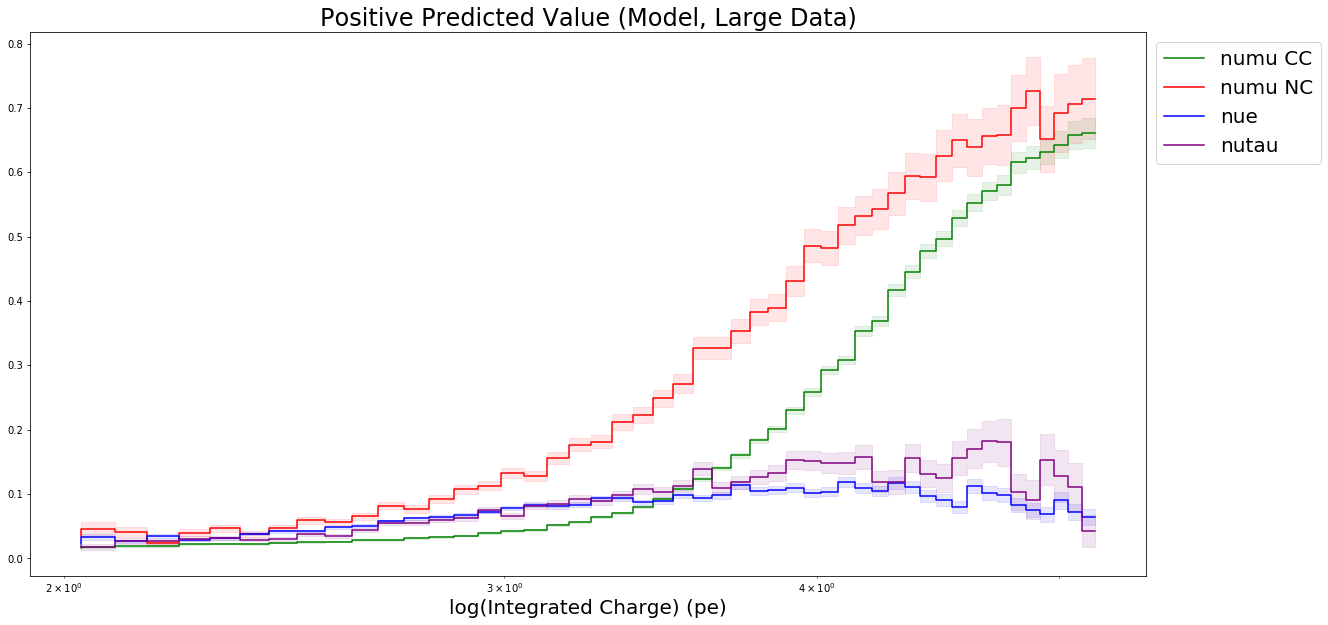

In [87]:
ppr_plot(y_model_large_data, data.targets[large_data_idx], charge[large_data_idx], 
         pdg_encodings[large_data_idx], interaction_type[large_data_idx],
        'Positive Predicted Value (Model, Large Data)', plots)

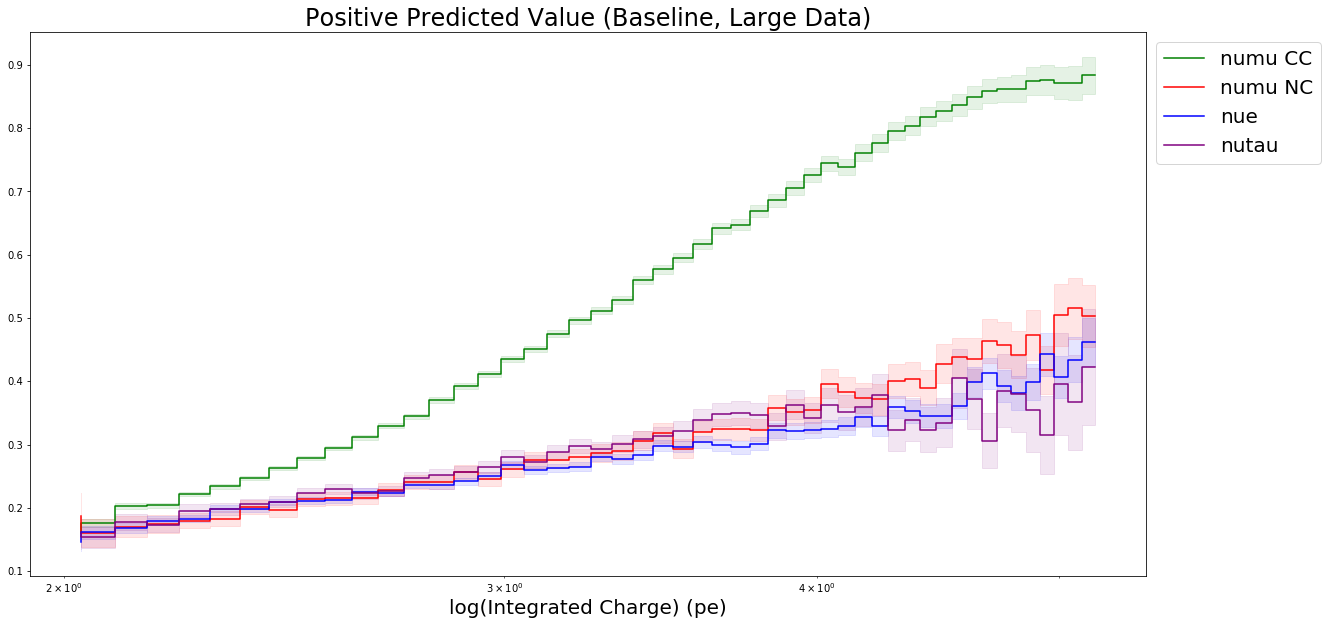

In [86]:
ppr_plot(y_baseline[large_data_idx], data.targets[large_data_idx], charge[large_data_idx], 
         pdg_encodings[large_data_idx], interaction_type[large_data_idx],
        'Positive Predicted Value (Baseline, Large Data)', plots)

In [47]:
acc_model_large_data = (y_model_large_data == data.targets[large_data_idx]).sum() / y_model_large_data.shape[0]
acc_baseline_large_data = (y_baseline[large_data_idx] == data.targets[large_data_idx]).sum() / y_model_large_data.shape[0]
acc_model_large_data, acc_baseline_large_data

(0.37931659864097167, 0.5603441765919808)

<ErrorbarContainer object of 3 artists>

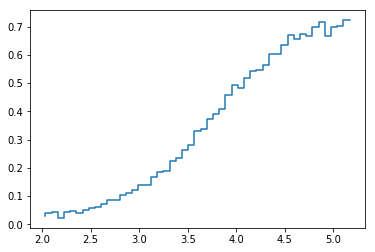

In [49]:
is_numunc = (np.logical_and((np.abs(pdg_encodings) == 14), (interaction_type == 2)))[large_data_idx]
model_preds_numunc = y_model_large_data[is_numunc]
log_charges_numunc = np.log(charge[large_data_idx][is_numunc])

# Bin the charges
bin_counts, bins = np.histogram(log_charges_numunc, bins=50, range=(2.0, 5.2))
bin_counts_positives, _ = np.histogram(log_charges_numunc[model_preds_numunc > 0], bins=bins)
ppr = bin_counts_positives / bin_counts
plt.errorbar(0.5 * (bins[1:] + bins[:-1]), ppr, drawstyle='steps')

# Check NuMu NC predictions from the model

In [50]:
pdg_encodings = data.file['PDGEncoding']['value'][test_idx]
interaction_type = data.file['InteractionType']['value'][test_idx]
# Find positive predictions of the model that are also NuMu NC
model_positives = y_model.astype(np.bool)
is_numu_nc = np.logical_and(interaction_type == 2, np.abs(pdg_encodings) == 14)
numu_nc_positives = np.logical_and(model_positives, is_numu_nc)
numu_nc_positives.sum() / is_numu_nc.sum()
numu_nc_positive_idx = test_idx[numu_nc_positives]

In [56]:
numu_nc_positve_idx_shuffled = numu_nc_positive_idx.copy()
np.random.shuffle(numu_nc_positve_idx_shuffled)
numu_nc_positve_idx_shuffled[:9]

array([132626,  45518, 210986,  88710, 120602, 128937, 190098,  84665,
        58167])

In [69]:
X, D, M = data.get_padded_batch(numu_nc_positve_idx_shuffled[:1000])
logits_ = model.predict_on_batch([X, D, M])

In [71]:
(logits_ > .5).sum()

1

In [51]:
data.file['TrackLength']['value'][numu_nc_positive_idx]

array([nan, nan, nan, ..., nan, nan, nan])

In [52]:
data.file['CascadeEnergy']['value'][numu_nc_positive_idx]

array([ 4.75584811,  2.97221309,  7.37752622, ..., 49.48427969,
        4.56047016, 14.87253192])

In [53]:
data.file['IC86_Dunkman_L6_SANTA_DirectCharge']['value'][numu_nc_positive_idx]

array([ 4.67499995, 12.40000015,  8.67499997, ..., 23.07499993,
       21.20000009, 11.55      ])

In [ ]:
data.file['PDGEncoding']['value'][numu_nc_positive_idx], np.std(np.abs(data.file['PDGEncoding']['value'][numu_nc_positive_idx]))

In [ ]:
data.file['InteractionType']['value'][numu_nc_positive_idx], np.std(data.file['InteractionType']['value'][numu_nc_positive_idx])

In [ ]:
y_model[]

In [ ]:
data.file.keys()

# Evaluate the model on the entire dataset
data = HD5Dataset('../data/data_dragon.hd5', seed=42, features=["FirstCharge", "CumulativeCharge", "Time",
            "VertexX", "VertexY", "VertexZ", "RecoX",
"RecoZ", "RecoAzimuth", "RecoZenith"])

In [ ]:
#run_idx = 'hd5-875239' Model without cutoff but class balancing
run_idx = 'hd5-860835'

In [ ]:
%ls training/{run_idx}

In [ ]:
with open(f'training/{run_idx}/config.json') as f:
    settings = json.load(f)

In [ ]:
data = util.dataset_from_config(settings)

In [ ]:
model = util.model_from_config(settings)

In [ ]:
model.load_weights(f'training/{run_idx}/model_weights.h5')

In [ ]:
model.weights

In [ ]:
data.get_baseline_accuracy()

In [ ]:
#test_idx = data._get_idx('test')
# Also append all idx that were kept from the model
#test_idx.shape

In [ ]:
data2_config = settings
settings['dataset']['max_charge'] = None
settings['dataset']['balance_classes'] = None
settings['dataset']['min_track_length'] = None
settings['dataset']['max_cascade_energy'] = None
data2 = util.dataset_from_config(data2_config)

In [ ]:
test_idx = data2._get_idx('test')
test_idx.shape

In [ ]:
# Evaluate the model on all the data
batch_size = 72
logits_model = model.predict_generator(data2.get_batches(batch_size=batch_size, dataset='test'),
                       steps=int(np.ceil(data2.size(dataset='test') / batch_size)), verbose=1)

In [ ]:
logits_model

In [ ]:
np.unique(logits_model).shape

In [ ]:
y_model = (logits_model >= 0.5).astype(np.int)

In [ ]:
np.unique(y_model)

In [ ]:
y_model = y_model.squeeze()

In [ ]:
# Get the pe counts (~charge) of the test data
total_charge = data.file['TotalCharge']['value'][test_idx]

In [ ]:
y_gnd = data.targets[test_idx]
y_baseline = (data.delta_loglikelihood[test_idx] >= 2.0).astype(np.uint8)

In [ ]:
y_model.shape, y_gnd.shape, y_baseline.shape

In [ ]:
total_charge
total_charge.max(), total_charge.min()

In [ ]:
bins = np.logspace(0.8, 3.2)
binned = np.digitize(total_charge, bins)
#np.unique(binned)

In [ ]:
def get_metrics(y_pred, y_gnd):
    acc = (y_pred == y_gnd).sum() / len(y_pred)
    tpr = (y_pred[y_gnd == 1] == 1).sum() / ((y_gnd == 1).sum() + 1e-20)
    tnr = (y_pred[y_gnd == 0] == 0).sum() / ((y_gnd == 0).sum() + 1e-20)
    ppr = (y_pred == 1).sum() / y_pred.shape[0]
    return acc, tpr, tnr, ppr

In [ ]:
pgd_encoding = np.array(data.file['PDGEncoding']['value'], dtype=np.uint8).astype(np.int8)
pgd_encoding.shape

In [ ]:
(np.abs(pgd_encoding) == 12).sum()

In [ ]:
interaction_types = np.array(data.file['InteractionType']['value'], dtype=np.uint8)
interaction_types

In [ ]:
np.unique(pgd_encoding, return_counts=True)

In [ ]:
np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).sum() / interaction_types.shape[0]

In [ ]:
np.unique(interaction_types)

In [ ]:
data.file.keys()

In [ ]:
y_gnd2 = np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).astype(np.int)

In [ ]:
metrics = defaultdict(lambda: defaultdict(list))
for bin_idx, value in enumerate(bins):
    for interaction_type, pgd_code in (('nue', 12), ('numu CC', 14), ('numu NC', 14), ('nutau', 16)):
        # print((np.abs(pgd_encoding) == pgd_code).sum(), pgd_code)
        bin_mask = binned == bin_idx
        enc_mask = np.abs(pgd_encoding[test_idx] == pgd_code)
        if 'numu' in interaction_type:
            it = 1 if 'CC' in interaction_type else 2
            it_mask = interaction_types[test_idx] == it
            #print(it, it_mask.sum())
            idxs = np.where(np.logical_and(bin_mask, np.logical_and(enc_mask, it_mask)))[0]
        else:
            idxs = np.where(np.logical_and(bin_mask, enc_mask))[0]
        # print(idxs.shape)
        for y, t in ((y_model, 'model'), (y_baseline, 'baseline')):
            acc, tpr, tnr, ppr = get_metrics(y[idxs], y_gnd[idxs])
            metrics[interaction_type][t].append({
                'acc' : acc, 'tpr' : tpr, 'ppr' : ppr, 'bin_idx' : bin_idx, 'value' : value, 'num_samples' : idxs.shape[0]
            })

In [ ]:
dfs = {
    pgd_code : {
            type_ : pd.DataFrame(data) for type_, data in metrics_code.items()
        } for pgd_code, metrics_code in metrics.items()
    }
for pgd_code, metrics_code in dfs.items():
    for type_, df in metrics_code.items():
        df = df[df['num_samples'] > 100]
        metrics_code[type_] = df

In [ ]:
dfs['numu NC']

In [ ]:
def plot_metric(metric, metric_name):
    colors = ['blue', 'green', 'red', 'purple']
    fig = plt.figure()
    plt.xscale('log')
    for (pgd_code, df), color in zip(dfs.items(), colors):
        for t in df.keys():
            if t == 'model':
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (model)', color=color)
            else:
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (baseline)', linestyle='dashed', color=color)
    plt.legend(loc='left', bbox_to_anchor=(1.0, 1.05))
    plt.title(metric_name)
    plt.ylim()
    plt.xlabel('log(Integrated Charge) (pe)')


In [ ]:
plot_metric('acc', 'Accuracy', )

In [ ]:
(y_model == y_gnd).sum() / y_gnd.shape[0]

In [ ]:
(y_baseline == y_gnd).sum() / y_gnd.shape[0]

In [ ]:
plot_metric('ppr', 'Predicted Positives')

In [ ]:
bins_track, bin_counts_track = np.unique(binned[y_gnd > 0], return_counts=True)
bins_non_track, bin_counts_non_track = np.unique(binned[y_gnd <= 0], return_counts=True)
bin_counts_non_track, bin_counts_track


In [ ]:
fig = plt.figure()
plt.xscale('log')
plt.step(bins[bins_track], bin_counts_track, label='Track')
plt.step(bins[bins_non_track], bin_counts_non_track, label='No Track')
plt.legend()
plt.xlim(right=2e2)
plt.title('Event Counts')
plt.xlabel('log(Integrated Charge) (pe)')

In [ ]:
np.hstack((
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc']),
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc'])
    )
)

In [ ]:
total_charge_sorted = np.sort(total_charge)

In [ ]:
# Find different cutoff values to check performance at different maximal energies by selecting the quantiles of the data
cutoffs = []
quantiles = []
for quantile in np.arange(0.00, 1.0, 0.01):
    quantile = 1.0 - quantile
    quantiles.append(quantile)
    cutoffs.append(total_charge_sorted[int(total_charge.shape[0] * quantile) - 1])

In [ ]:
y_model.shape, y_gnd.shape

In [ ]:
metrics = defaultdict(lambda: defaultdict(list))
for cutoff, quantile in zip(cutoffs, quantiles):
    mask = total_charge <= cutoff
    acc_baseline, tpr_baseline, tnr_baseline, ppr_baseline = get_metrics(y_baseline[mask], y_gnd[mask])
    metrics['baseline']['accuracy'].append(acc_baseline)
    metrics['baseline']['tpr'].append(tpr_baseline)
    metrics['baseline']['tnr'].append(tnr_baseline)
    metrics['baseline']['ppr'].append(ppr_baseline)
    acc_model, tpr_model, tnr_model, ppr_model = get_metrics(y_model[mask], y_gnd[mask])
    metrics['model']['accuracy'].append(acc_model)
    metrics['model']['tpr'].append(tpr_model)
    metrics['model']['tnr'].append(tnr_model)
    metrics['model']['ppr'].append(ppr_model)
    metrics['gnd']['ppr'].append((y_gnd[mask] == 1).sum() / y_gnd[mask].shape[0])

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax1.plot(cutoffs, metrics['baseline']['accuracy'], label='Baseline')
ax1.plot(cutoffs, metrics['model']['accuracy'], label='Model')
ax1.set_title('Accuracy', fontsize=18)
ax1.legend(fontsize=18)
ax2 = fig.add_subplot(132)
ax2.plot(cutoffs, metrics['baseline']['tpr'], label='Baseline')
ax2.plot(cutoffs, metrics['model']['tpr'], label='Model')
ax2.set_title('True Positive Rate', fontsize=18)
ax2.legend(fontsize=18)
ax3 = fig.add_subplot(133)
ax3.plot(cutoffs, metrics['baseline']['tnr'], label='Baseline')
ax3.plot(cutoffs, metrics['model']['tnr'], label='Model')
ax3.set_title('True Negative Rate', fontsize=18)
ax3.legend(fontsize=18)
fig.text(0.5, 0.04, 'Integrated Charge (pe)', ha='center', va='center', fontsize=18)



In [ ]:
fig = plt.figure()
plt.plot(cutoffs, metrics['baseline']['ppr'], label='Baseline')
plt.plot(cutoffs, metrics['model']['ppr'], label='Model')
plt.plot(cutoffs, metrics['gnd']['ppr'], label='Truth')
plt.legend()


In [ ]:
model.summary()

In [ ]:
model.weights

In [ ]:
np.unique(y_model)

# Investigate attributes of the dataset

In [ ]:
file = h5py.File('../data/data_dragon2.hd5')

In [ ]:
idx = np.arange(file['TimeStdDeviation'].shape[0])
np.random.shuffle(idx)

In [ ]:
samples = idx[:100000]

In [ ]:
file.keys()

In [ ]:
time_std_samples = file['TimeStdDeviation']['item'][samples]

In [ ]:
time_std_samples = time_std_samples[time_std_samples < 1e-5]

In [ ]:
time_std_samples

In [ ]:
plt.hist(time_std_samples, bins=100)

In [ ]:
charge_samples = file['ChargeFirstPulse']['item'][samples]

In [ ]:
charge_samples = charge_samples[charge_samples <= 5]

In [ ]:
plt.hist(charge_samples, bins=100)

In [ ]:
time_samples = file['TimeFirstPulse']['item'][samples]

In [ ]:
time_samples_filtered = time_samples[time_samples > -0.002]

In [ ]:
time_samples_filtered.std()